# 第四章作业

本次作业我们加强对图嵌入模型的实践，具体地，我们需要利用gensim.Word2Vec模型来实现Node2Vec模型。

在开始实践之前，首先请同学回答两个问题：
1. Node2Vec模型中的p参数和q参数各代表什么意思？
2. 在Node2Vec采样随机游走时，如果我们鼓励随机游走访问之前被采样过的节点，我们应该如何调节p或者q？

## 代码填空 - Node2Vec采样随机游走

In [1]:
! touch /opt/anaconda/envs/graph/lib/python3.7/site-packages/smart_open/open.py

In [2]:
import numba
import numpy as np
import scipy.sparse as sp
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
def node2vec(
    adj, 
    embedding_dim=64, 
    walk_length=30, 
    walks_per_node=10,
    workers=8, 
    window_size=10, 
    num_neg_samples=10, 
    p=4, 
    q=1
):
    """
    参数说明
    -------------
    adj : 图的邻接矩阵
    embedding_dim : 图嵌入的维度
    walk_length : 随机游走的长度
    walks_per_node : 每个节点采样多少个随机游走
    workers: word2vec模型使用的线程数量
    window_size: word2vec模型中使用的窗口大小
    num_neg_samples : 负样本的数量
    p: node2vec的p参数
    q: node2vec的q参数
    """
    # step 1: node2vec second-order random walk
    (V, walks) = sample_n2v_random_walks(
        adj, 
        walk_length, 
        walks_per_node, 
        p=p, 
        q=q
    )
    # step 2: format sampled walks as sentences:
    walks = [
        list(map(str, walk)) for walk in walks
    ]
    # step 3: call word2vec:
    model = Word2Vec(
        sentences=walks, 
        size=embedding_dim, 
        negative=num_neg_samples, compute_loss=True
    )
    # step 4: extract node embeddings:
    embedding = np.asarray(
        [model.wv.get_vector(str(node_id)) for node_id in range(V)]
    )
    # done:
    return (model, embedding)

def sample_n2v_random_walks(adj, walk_length, walks_per_node, p, q):
    """
    返回值的类型
    -------
    walks : np.ndarray, shape [num_walks * num_nodes, walk_length]
        采样后的随机游走
    """
    # format as Compressed Sparse Row matrix, which enables indexing:
    adj = sp.csr_matrix(adj)
    
    # num. of vertices:
    V = len(adj.indptr) - 1
    
    # do node2vec second-order random walk:
    random_walks = _n2v_random_walk_numba(
        adj.indptr,
        adj.indices,
        walk_length,
        walks_per_node,
        p,
        q
    )
    
    return (V, random_walks) 

In [4]:
def _n2v_random_walk(
    indptr,
    indices,
    walk_length,
    walks_per_node,
    p,
    q
):
    # num. of nodes:
    V = len(indptr) - 1
    
    # init output:
    final_walks = []
    for _ in range(walks_per_node):
        for start in range(V):
            # init current walk:
            (prev, curr) = (start, start)
            walk = [curr]
            
            if walk_length > 1:
                # implement node2vector random walk:
                for _ in range(walk_length - 1):
                    # get previous context:
                    prev_context = set(
                        indices[indptr[prev]:indptr[prev+1]]
                    )
                    # get current context:
                    curr_context = set(
                        indices[indptr[curr]:indptr[curr+1]]
                    )
                                        
                    # set sampling weights:
                    context = dict()

                    # option 1 -- current neighbor is parent:
                    if prev in curr_context:
                        context[prev] = (1.0 / p)
                        
                    # option 2 -- distance to parent is 1:
                    for neighbor in curr_context.intersection(prev_context):
                        if (neighbor != prev):
                            context[neighbor] = 1.0

                    # option 3 -- distance to parent is 2:
                    for neighbor in curr_context.difference(prev_context):
                        if (neighbor != prev):
                            context[neighbor] = (1.0 / q)

                    #
                    # sample by weights:
                    #
                    # preparation -- get candidate neighbors:
                    neighbors = np.asarray(list(context.keys()), dtype=np.int32)
                    # preparation -- get sampling probabilities:
                    weights = np.asarray(list(context.values()), dtype=np.float32)
                    probs = weights / np.sum(weights)
                    # sample by probabilities:
                    (prev, curr) = (
                        curr, np.random.choice(neighbors, size=None, p=probs)
                    )
                    
                    # done:
                    walk.append(curr)
                    
            # done:
            final_walks.append(walk)
    
    # done:
    return np.array(final_walks)

@numba.jit(nopython=True)
def random_choice(arr, p):
    """ sample node by probability """
    return arr[np.searchsorted(np.cumsum(p), np.random.random(), side="right")]

@numba.jit(nopython=True)
def _n2v_random_walk_numba(
    indptr,
    indices,
    walk_length,
    walks_per_node,
    p,
    q
):
    # num. of nodes:
    V = len(indptr) - 1
    
    for _ in range(walks_per_node):
        for start in range(V):
            # init current walk:
            (prev, curr) = (start, start)
            walk = [curr]
            
            if walk_length > 1:
                # implement node2vector random walk:
                for _ in range(walk_length - 1):
                    # get previous context:
                    prev_context = set(
                        indices[indptr[prev]:indptr[prev+1]]
                    )
                    # get current context:
                    curr_context = set(
                        indices[indptr[curr]:indptr[curr+1]]
                    )
                                        
                    # set sampling weights:
                    context = dict()

                    # option 1 -- current neighbor is parent:
                    if prev in curr_context:
                        context[prev] = (1.0 / p)
                        
                    # option 2 -- distance to parent is 1:
                    for neighbor in curr_context.intersection(prev_context):
                        if (neighbor != prev):
                            context[neighbor] = 1.0

                    # option 3 -- distance to parent is 2:
                    for neighbor in curr_context.difference(prev_context):
                        if (neighbor != prev):
                            context[neighbor] = (1.0 / q)

                    #
                    # sample by weights:
                    #
                    # preparation -- get candidate neighbors:
                    neighbors = np.asarray(list(context.keys()), dtype=np.int32)
                    # preparation -- get sampling probabilities:
                    weights = np.asarray(list(context.values()), dtype=np.float32)
                    probs = weights / np.sum(weights)
                    # sample by probabilities:
                    (prev, curr) = (
                        curr, random_choice(neighbors, p=probs)
                    )
                    
                    # done:
                    walk.append(curr)
                    
            yield walk

## 代码填空- 完成测试代码

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_scipy_sparse_matrix

In [6]:
# TODO: here Cora dataset must be manually downloaded and put it here
dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]
adj = to_scipy_sparse_matrix(data.edge_index)

In [7]:
# get fitted model and embeddings:
model, embedding = node2vec(adj, embedding_dim=64, p=2, q=0.5)
embedding.shape

(2708, 64)

/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


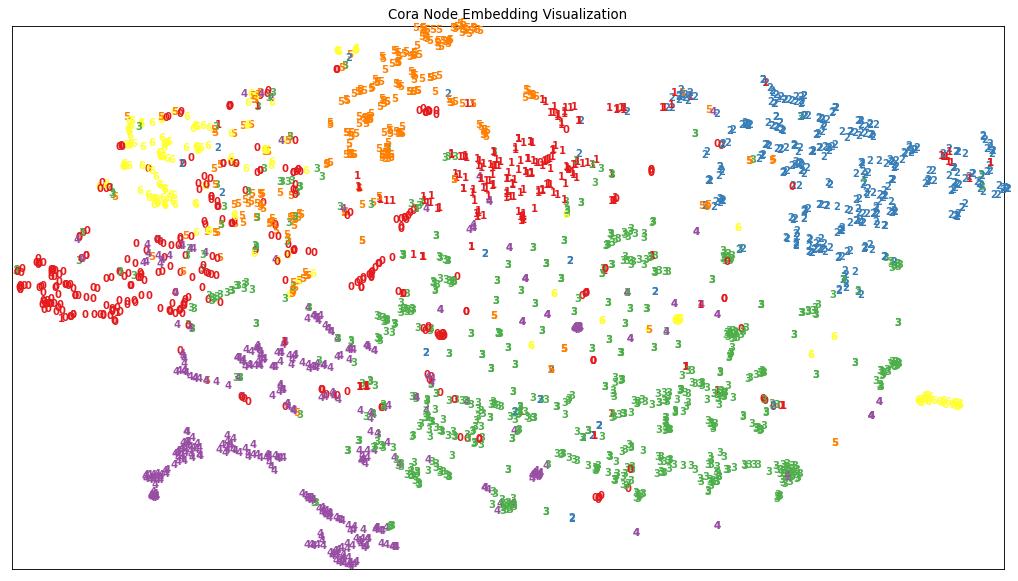

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embedding(
    embeddings, labels, 
    title
):
    """plot node embedding with tSNE"""
    # fit tSNE:
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    data = tsne.fit_transform(
        normalize(embeddings)
    )
    
    # preprocess for visualization:
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
     
    # visualize:
    (V, _) = data.shape
    
    fig = plt.figure(figsize=(16, 9), dpi=80)
    ax = plt.subplot(111)
    for node_id in range(V):
        plt.text(
            data[node_id, 0], data[node_id, 1], str(labels[node_id]),
            color=plt.cm.Set1(labels[node_id] / 10.),
            fontdict={'weight': 'bold', 'size': 9}
        )
        
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
    return fig

plt.show(
    plot_embedding(
        embedding, np.asarray(data.y), 
        'Cora Node Embedding Visualization'
    )
)

In [9]:
def evaluate_node_classification(
    embedding_matrix, labels, 
    train_mask, test_mask, 
    normalize_embedding=True, max_iter=1000
):      
    """ use single-layer MLP for node label prediction using node2vec embeddings
    """
    # normalize:
    X = embedding_matrix
    if normalize_embedding:
        X = normalize(embedding_matrix)
    
    # split train-test sets:
    X_train, y_train = X[train_mask, :], labels[train_mask]
    X_test, y_test = X[test_mask, :], labels[test_mask]
    
    # build classifier:
    clf = MLPClassifier(
        random_state=42,
        hidden_layer_sizes=[32],
        max_iter=max_iter
    ).fit(X_train, y_train)
    
    # make prediction:
    preds = clf.predict(X_test)
    
    # get classification report:
    print(
        classification_report(
            y_true=y_test, y_pred=preds
        )
    )
    # get accuracy score:
    test_acc = accuracy_score(y_true=y_test, y_pred=preds)
    
    return preds, test_acc

In [10]:
preds, test_acc = evaluate_node_classification(
    embedding, np.asarray(data.y), 
    np.asarray(data.train_mask), 
    np.asarray(data.test_mask)
)
print('Test Acc: %.4f' % test_acc)

              precision    recall  f1-score   support

           0       0.52      0.62      0.56       130
           1       0.68      0.80      0.73        91
           2       0.89      0.78      0.83       144
           3       0.81      0.60      0.68       319
           4       0.63      0.62      0.62       149
           5       0.57      0.76      0.65       103
           6       0.47      0.67      0.55        64

    accuracy                           0.67      1000
   macro avg       0.65      0.69      0.66      1000
weighted avg       0.70      0.67      0.67      1000

Test Acc: 0.6690


## 拓展问题

请同学们调节p参数和q参数，对比Node2Vec模型的效果和DeepWalk模型(p=q=1)的效果。